### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [64]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import seaborn as sns
%load_ext sql
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


#### Step 2: Examine your data 

In [8]:
df_raw = pd.read_csv("../assets/airport_cancellations.csv")
df = df_raw.dropna() 
df.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


### Intro: Write a problem statement / aim for this project

We want to understand the behavior of flight cancellations
Answer: 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [2]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432')

In [32]:
conn = engine.connect()
conn.execute("commit")
conn.execute("create database airport")
conn.close()

Load our csv files into tables

In [6]:
%sql postgresql://localhost:5432/airport

u'Connected: None@airport'

In [30]:
%%sql
DROP TABLE IF EXISTS airport_cancellations;
CREATE TABLE airport_cancellations
(airport VARCHAR,
 year FLOAT,
 departure_cancellations FLOAT,
 arrival_cancellations FLOAT,
 departure_diversions FLOAT,
 arrival_diversions FLOAT);


COPY airport_cancellations FROM '/Users/annacrawford/Colin/GA/Week1/DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/airport_cancellations.csv' DELIMITER ',' CSV HEADER;

Done.
Done.
805 rows affected.


[]

In [34]:
%%sql
DROP TABLE IF EXISTS airport_operations;
CREATE TABLE airport_operations
(airport1 VARCHAR,
 year1 FLOAT,
 departures_for_metric_computation FLOAT,
 arrivals_for_metric_computation FLOAT,
 percent_on_time_gate_departures FLOAT,
 percent_on_time_airport_departures FLOAT,
 percent_on_time_gate_arrivals FLOAT,
 average_gate_departure_delay FLOAT,
 average_taxi_out_time FLOAT,
 average_taxi_out_delay FLOAT,
 average_airport_departure_delay FLOAT,
 average_airborne_delay FLOAT,
 average_taxi_in_delay FLOAT,
 average_block_delay FLOAT,
 average_gate_arrival_delay FLOAT);


COPY airport_operations FROM '/Users/annacrawford/Colin/GA/Week1/DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/Airport_operations.csv' DELIMITER ',' CSV HEADER;

Done.
Done.
841 rows affected.


[]

In [35]:
%%sql
DROP TABLE IF EXISTS airports;
CREATE TABLE airports
(Key FLOAT,
 LocID VARCHAR,
 AP_NAME VARCHAR,
 ALIAS VARCHAR,
 Facility_Type VARCHAR,
 FAA_REGION VARCHAR,
 COUNTY VARCHAR,
 CITY VARCHAR,
 STATE VARCHAR,
 AP_Type VARCHAR,
 Latitude FLOAT,
 Longitude FLOAT,
 Boundary_Data_Available VARCHAR);


COPY airports FROM '/Users/annacrawford/Colin/GA/Week1/DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/airports.csv' DELIMITER ',' CSV HEADER;

Done.
Done.
5167 rows affected.


[]

Join airport_cancellations.csv and airports.csv into one table

In [40]:
%%sql
CREATE TABLE airport_canc AS(SELECT * FROM
                airport_cancellations
                INNER JOIN airports
                ON airport_cancellations.airport=airports.locid)

805 rows affected.


[]

Query the database for our intial data

In [12]:
%%sql
SELECT * FROM airport_canc
LIMIT 5

5 rows affected.


airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
ABQ,2005.0,221.0,190.0,61.0,33.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
ABQ,2006.0,392.0,329.0,71.0,124.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
ABQ,2007.0,366.0,304.0,107.0,45.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
ABQ,2008.0,333.0,300.0,79.0,42.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes


In [20]:
%%sql
SELECT * FROM airport_operations
LIMIT 5

5 rows affected.


airport1,year1,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
ABQ,2004.0,53971.0,53818.0,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
ABQ,2005.0,51829.0,51877.0,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [19]:
%%sql
CREATE TABLE total AS(SELECT * FROM
                airport_canc ac
                INNER JOIN airport_operations ao
                ON ac.locid = ao.airport1 AND ac.year = ao.year1)

799 rows affected.


[]

In [22]:
%%sql 
SELECT * FROM total
LIMIT 5

5 rows affected.


airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,airport1,year1,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2004.0,53971.0,53818.0,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
ABQ,2005.0,221.0,190.0,61.0,33.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2005.0,51829.0,51877.0,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
ABQ,2006.0,392.0,329.0,71.0,124.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
ABQ,2007.0,366.0,304.0,107.0,45.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
ABQ,2008.0,333.0,300.0,79.0,42.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [19]:
engine = create_engine('postgresql://localhost:5432/airport')
conn=engine.connect()
df=pd.read_sql_table('total',con=conn)

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [20]:
df.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,key,locid,ap_name,alias,...,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [21]:
df.columns

Index([u'airport', u'year', u'departure_cancellations',
       u'arrival_cancellations', u'departure_diversions',
       u'arrival_diversions', u'key', u'locid', u'ap_name', u'alias',
       u'facility_type', u'faa_region', u'county', u'city', u'state',
       u'ap_type', u'latitude', u'longitude', u'boundary_data_available',
       u'airport1', u'year1', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on_time_gate_departures',
       u'percent_on_time_airport_departures', u'percent_on_time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')

In [22]:
df=df.drop(['locid',
            'airport1',
            'year1',
            'boundary_data_available',
            'key',
            'ap_name',
            'alias',
            'facility_type',
            'county',
            'city'],axis=1)

In [23]:
df.columns

Index([u'airport', u'year', u'departure_cancellations',
       u'arrival_cancellations', u'departure_diversions',
       u'arrival_diversions', u'faa_region', u'state', u'ap_type', u'latitude',
       u'longitude', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on_time_gate_departures',
       u'percent_on_time_airport_departures', u'percent_on_time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')

In [24]:
df.head(2)

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,faa_region,state,ap_type,latitude,...,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial,35.040194,...,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,ASW,NM,Federalized/Commercial,35.040194,...,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [25]:
df.ap_type.value_counts()

Federalized/Commercial    748
Public Use                 51
Name: ap_type, dtype: int64

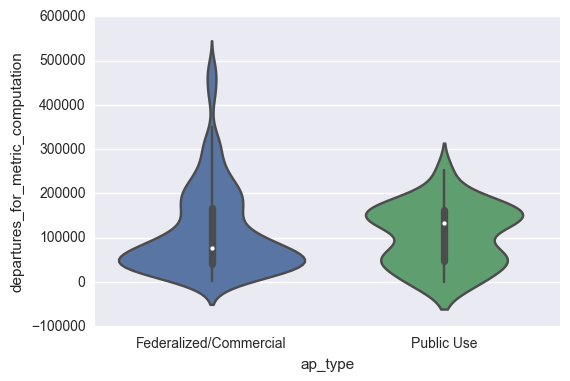

In [273]:
sns.violinplot(x=df.ap_type,y=df.departures_for_metric_computation)

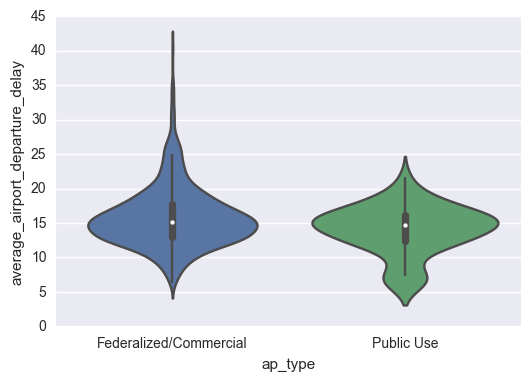

In [274]:
sns.violinplot(x=df.ap_type,y=df.average_airport_departure_delay)

According to the FAA public use airports are those in which aircraft have less then 2500 annual passenger boardings. It is quite suprising how many departures these airports see. I think it is less surpsiing that there is a larger amount of smaller delays in these airports as I would assume timetables are less strict then commerical airports.

In [26]:
df[['average_gate_departure_delay', 'average_taxi_out_time',
       'average_taxi_out_delay', 'average_airport_departure_delay',
       'average_airborne_delay', 'average_taxi_in_delay',
       'average_block_delay', 'average_gate_arrival_delay']].describe()

,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


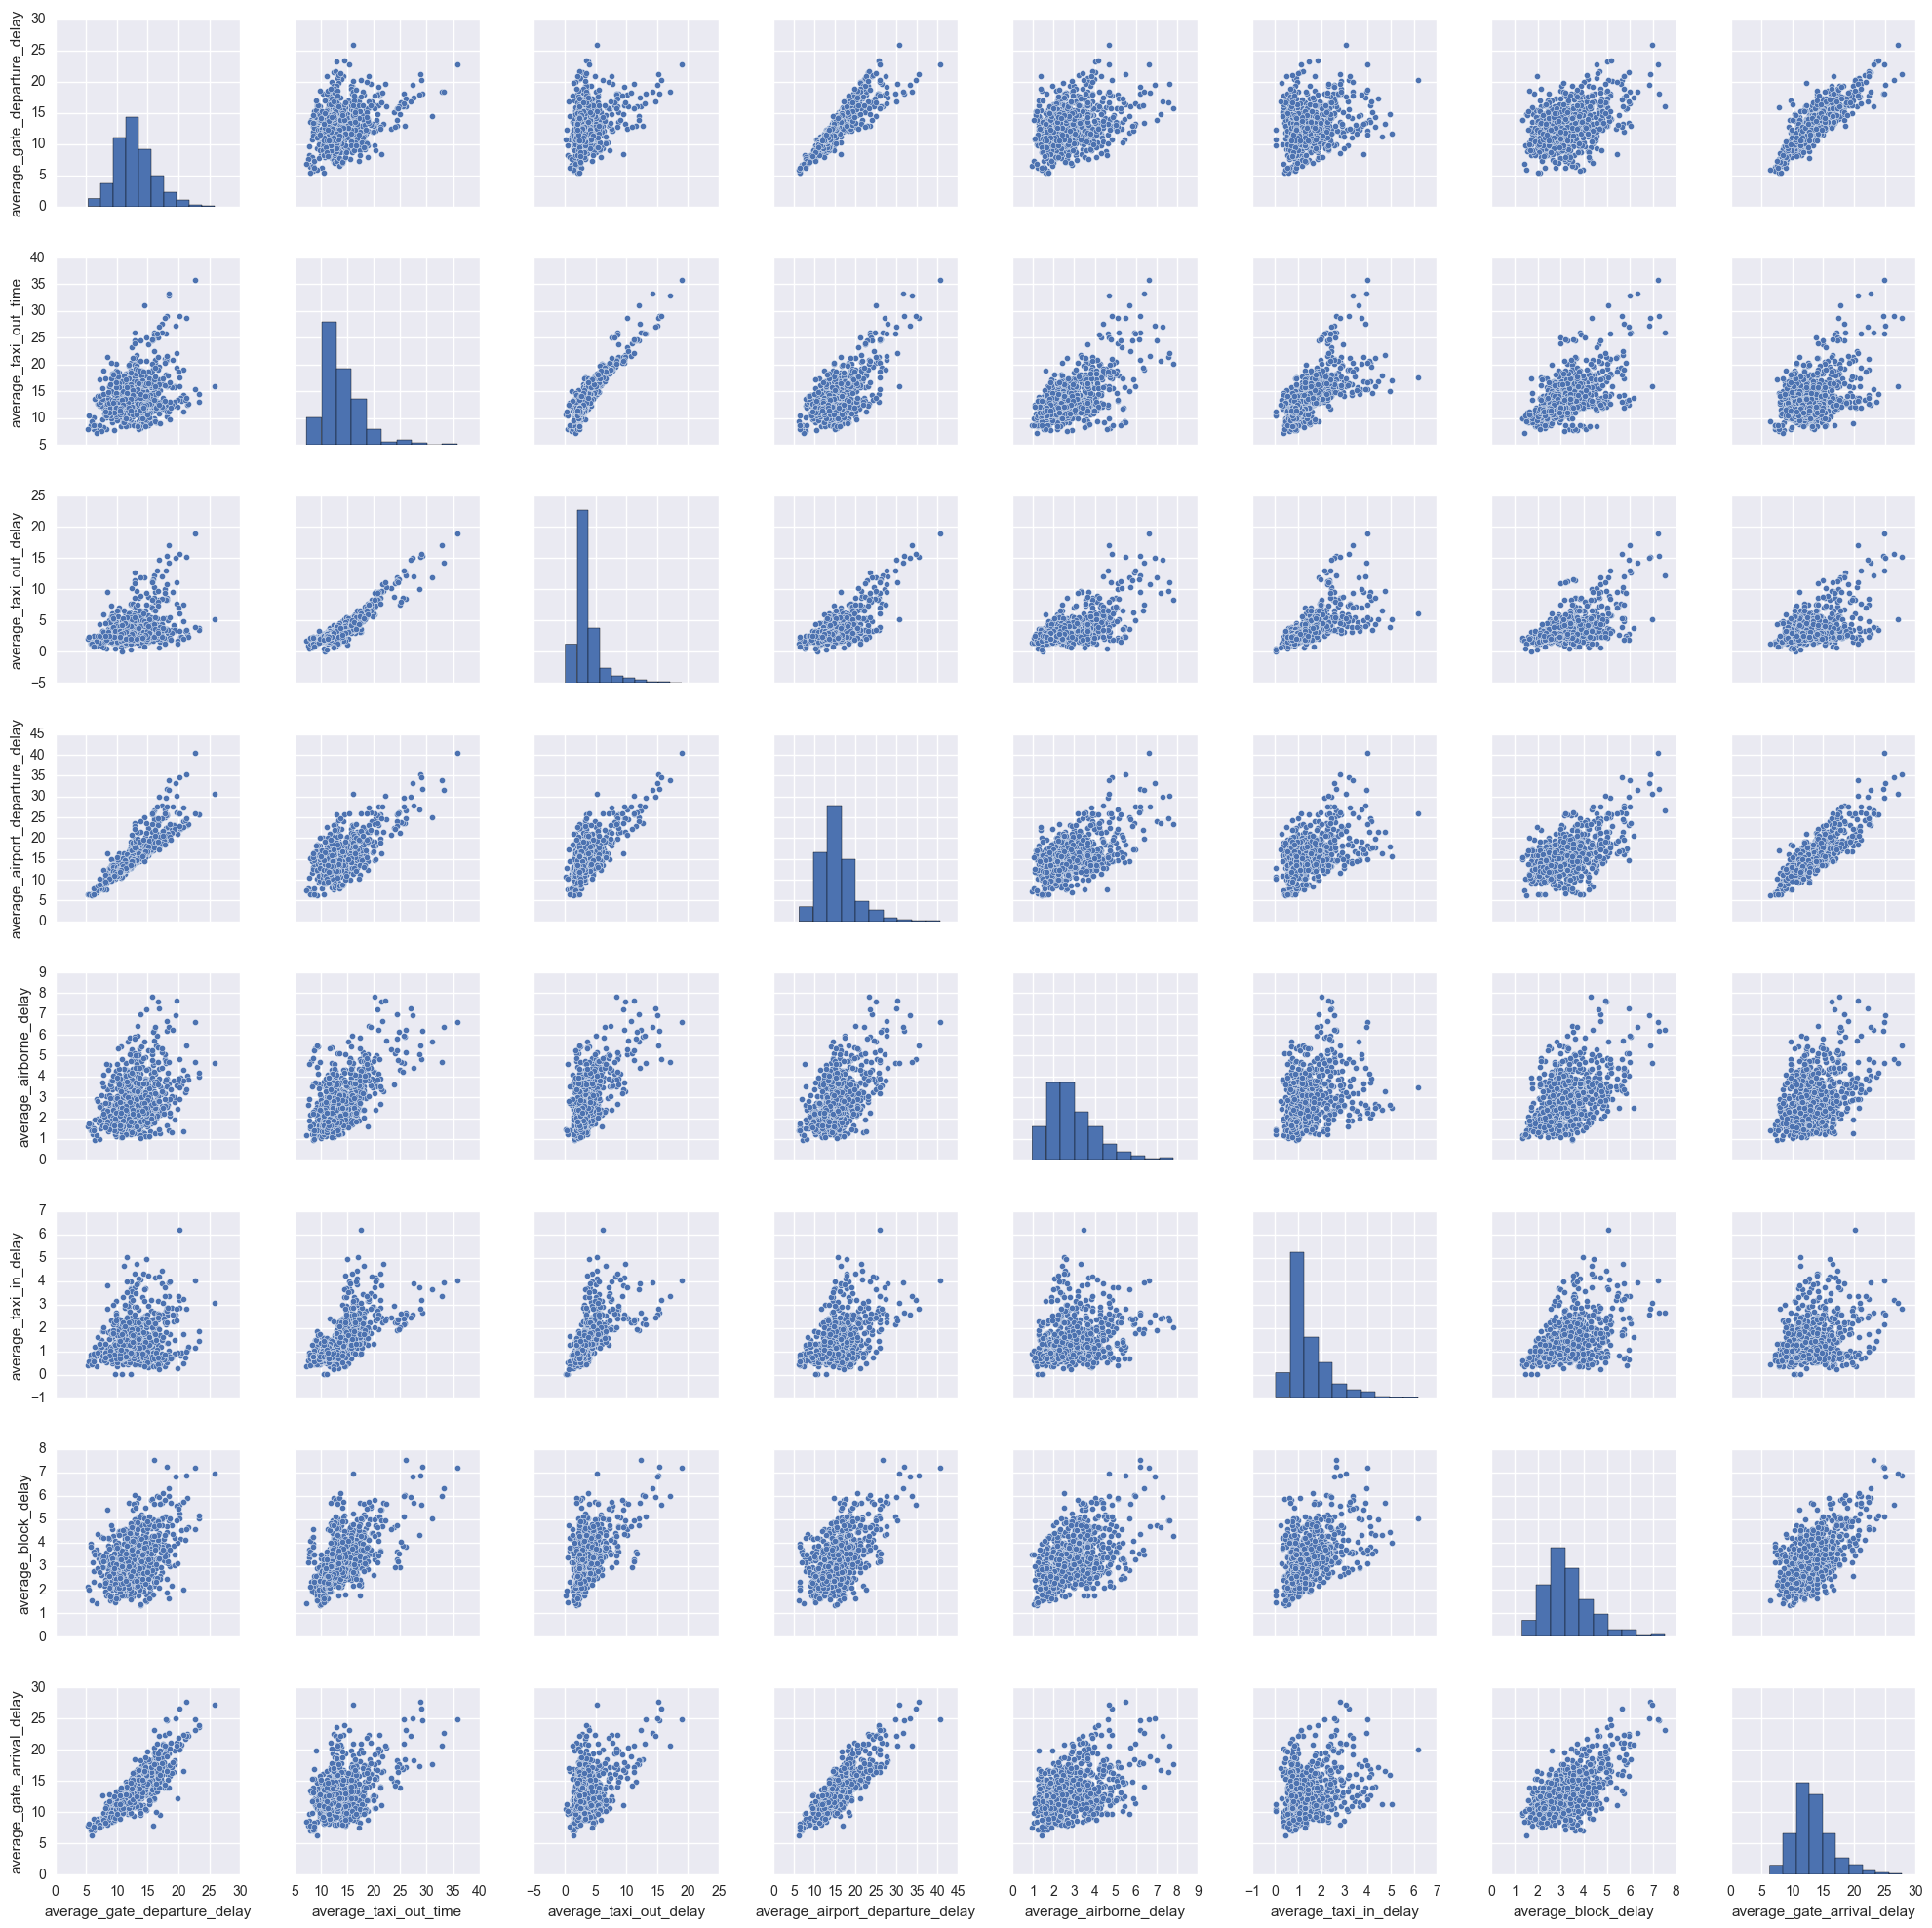

In [27]:
sns.pairplot(df[['average_gate_departure_delay', 'average_taxi_out_time',
       'average_taxi_out_delay', 'average_airport_departure_delay',
       'average_airborne_delay', 'average_taxi_in_delay',
       'average_block_delay', 'average_gate_arrival_delay']])

From the pairplot we can see that the majority of the delays are normally distrubited with a slight skew. The majorty of data points are clustered quite densely with a few outliers with higher delays. There are strong correlations between each type of delay, this shows that when one delay occurs there is naturally a knock on affect as airport operations are very tight.

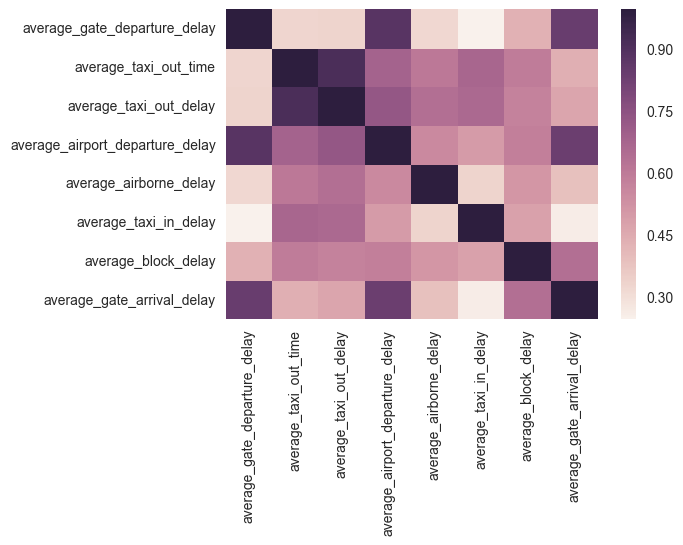

In [28]:
sns.heatmap(df[['average_gate_departure_delay', 'average_taxi_out_time',
       'average_taxi_out_delay', 'average_airport_departure_delay',
       'average_airborne_delay', 'average_taxi_in_delay',
       'average_block_delay', 'average_gate_arrival_delay']].corr())

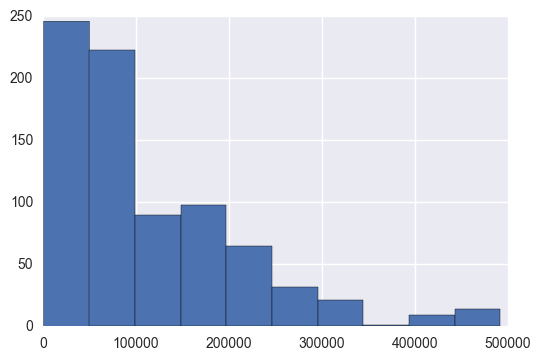

In [29]:
df['departures_for_metric_computation'].hist()

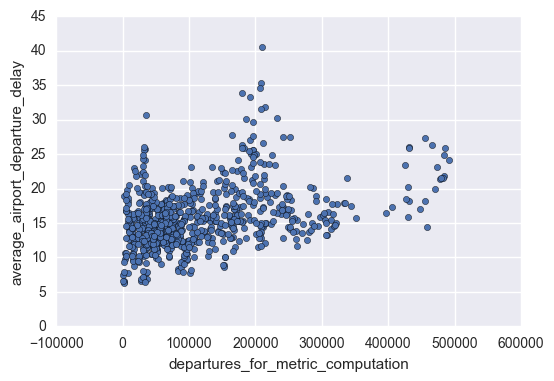

In [272]:
df.plot(x='departures_for_metric_computation',y='average_airport_departure_delay',kind='scatter')

The size of aiport varies quite significantly with the majority of airports operating with between 0-100000 flights with a select few operatinge up to 5 times this amount. There is a small correlation between airport size and average departure delay, however there are a group of significant outliers.

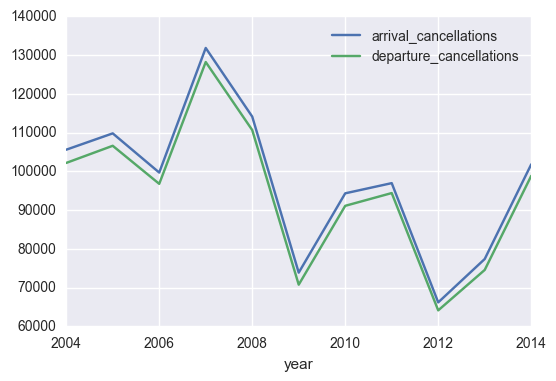

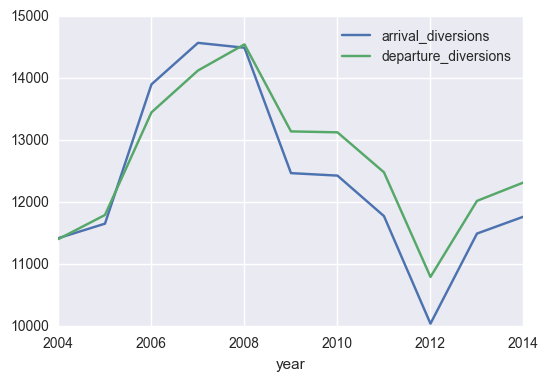

In [30]:
df.pivot_table(index='year',values=['departure_cancellations',
       'arrival_cancellations'],aggfunc=sum).plot()
df.pivot_table(index='year',values=['departure_diversions',
       'arrival_diversions'],aggfunc=sum).plot()

The number of cancellations and diversions per year has fluctuated quite significantly over the 10 year period. With around double the amount of cancellations in 2007 then there was in 2012 and about a 40% in crease in diversions, it appears that the diversions and cancellations are also increaseing from the 2012 low, however it is difficult to tell if this is a return to normal or will increase further as the number of data points is quite low.

In [31]:
Regions_df=df.pivot_table(index='faa_region',values=['departures_for_metric_computation',
       'arrivals_for_metric_computation'],aggfunc=sum)

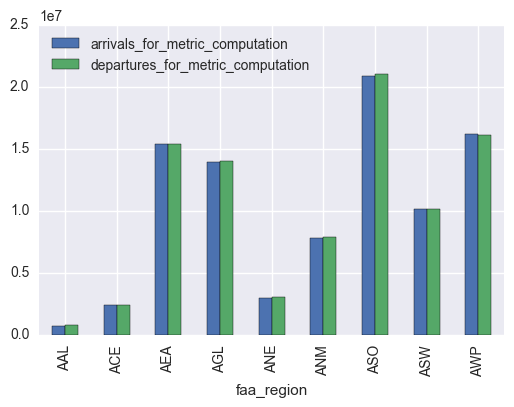

In [32]:
Regions_df.plot(kind='bar')

There is a huge gap between some of the faa regions in terms of the nuber of flights, however this is perhaps unuprising as some of these regions will cover Hawaii and Alaska which will have an exremely low number of flights in comparison to areas surrounding New York or California.

In [33]:
Facility_df=df.pivot_table(index='ap_type',values=['departures_for_metric_computation',
       'arrivals_for_metric_computation'],aggfunc=sum)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b96cc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12502e1d0>]], dtype=object)

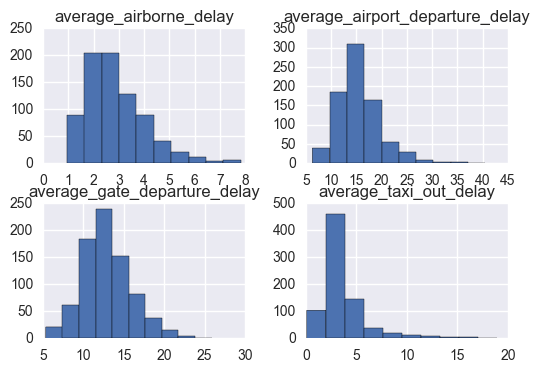

In [37]:
df[['average_gate_departure_delay','average_taxi_out_delay', 'average_airport_departure_delay',
       'average_airborne_delay']].hist()

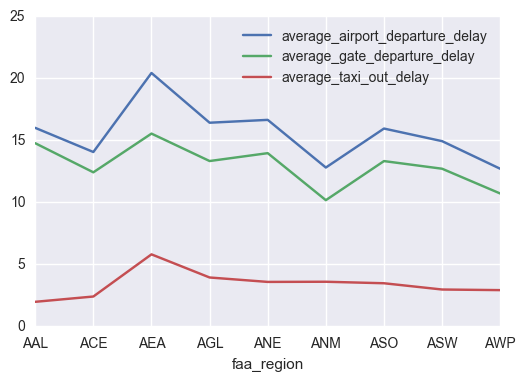

In [38]:
df.pivot_table(index='faa_region',values=['average_gate_departure_delay',
       'average_taxi_out_delay', 'average_airport_departure_delay'],aggfunc=np.mean).plot()

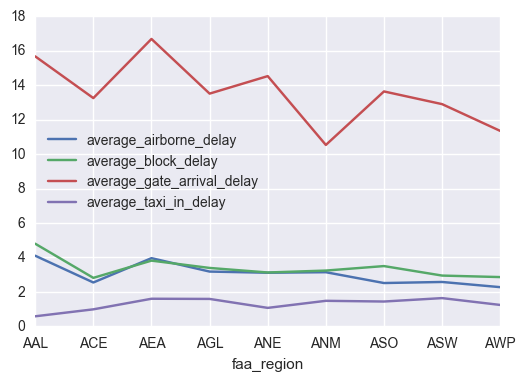

In [39]:
df.pivot_table(index='faa_region',values=['average_airborne_delay', 'average_taxi_in_delay',
       'average_block_delay', 'average_gate_arrival_delay'],aggfunc=np.mean).plot()

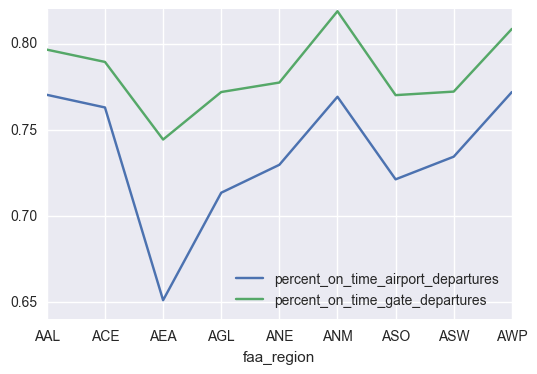

In [40]:
df.pivot_table(index='faa_region',values=['percent_on_time_gate_departures',
       'percent_on_time_airport_departures'],aggfunc=np.mean).plot()

It is clear that there are significantly more delays on flights within the AEA faa region, I suspect that any aiports which we find to be significantly disruptive may fall within this region.

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [106]:
Dummy_df=pd.get_dummies(data=df,columns=[u'faa_region', u'state', u'ap_type'])
Dummy_df.shape

(799, 68)

#### 3.2 Format and Clean the Data

In [139]:
X=Dummy_df.drop([u'year', u'latitude',u'longitude'],axis=1)

In [140]:
X=X.groupby('airport').mean().reset_index()

In [141]:
from sklearn.preprocessing import StandardScaler
X.ix[:,1:18]=StandardScaler().fit_transform(X.ix[:,1:18])
y=X.airport
X=X.drop('airport',axis=1)


### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

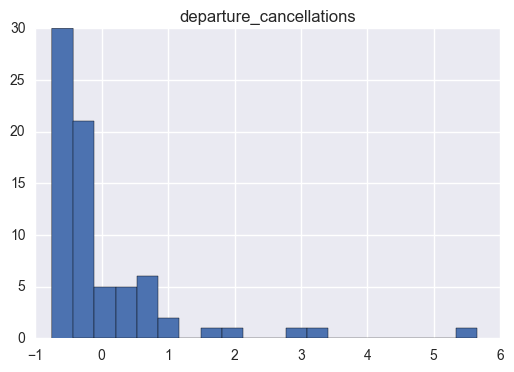

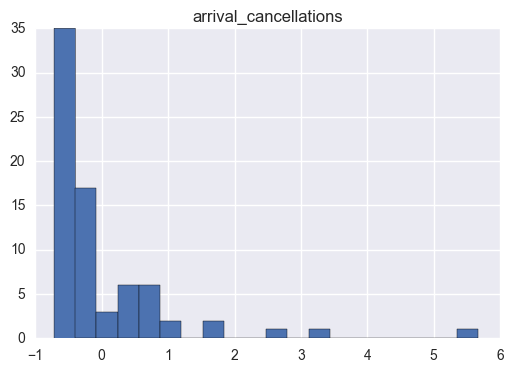

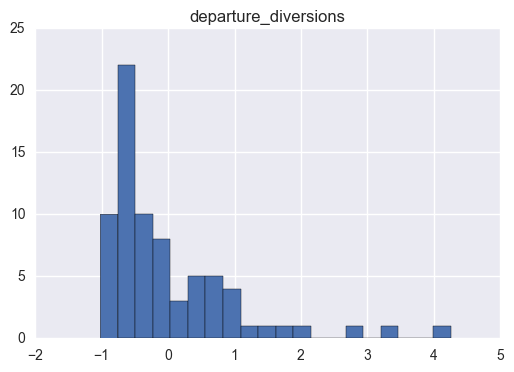

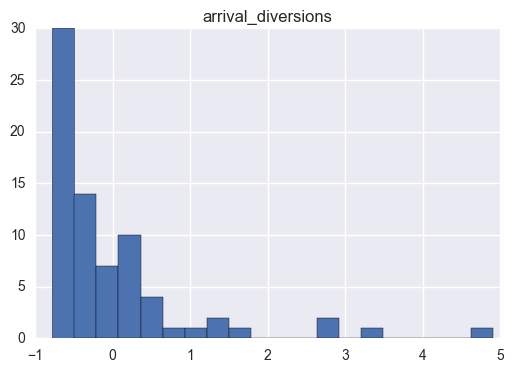

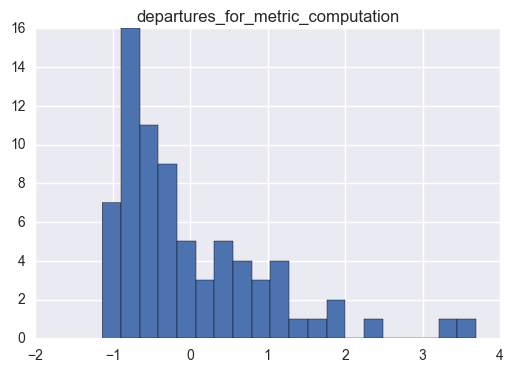

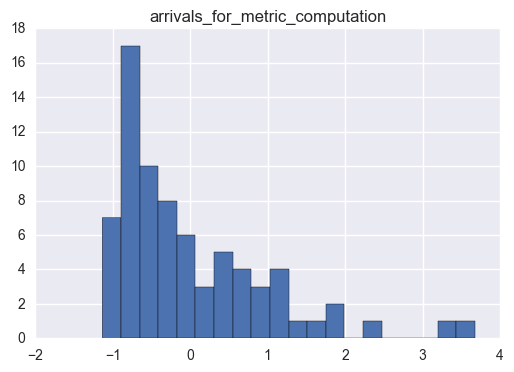

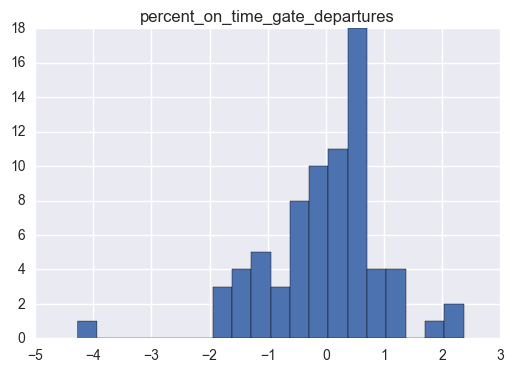

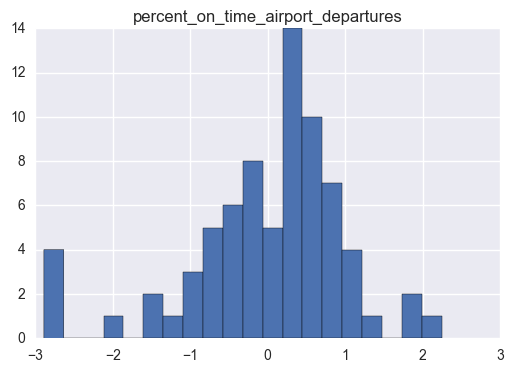

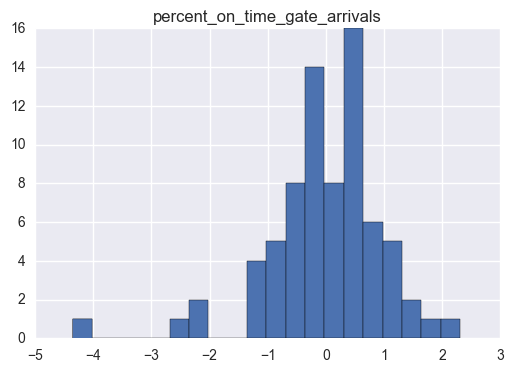

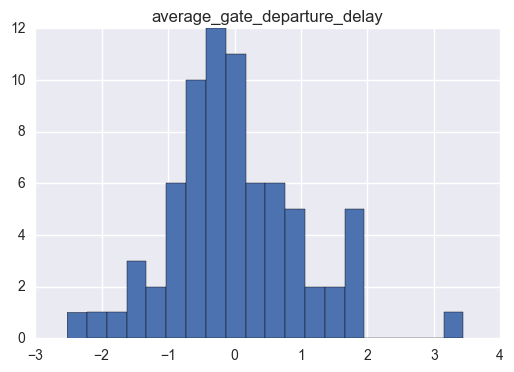

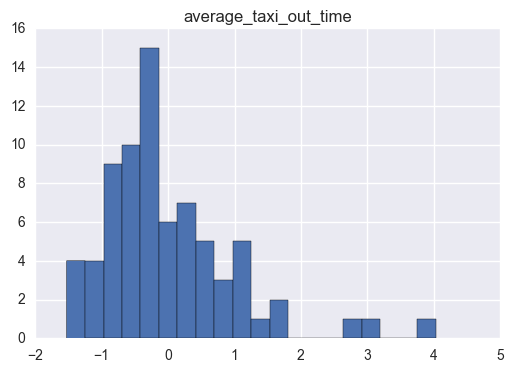

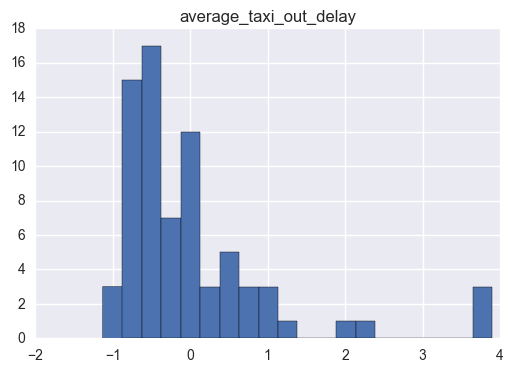

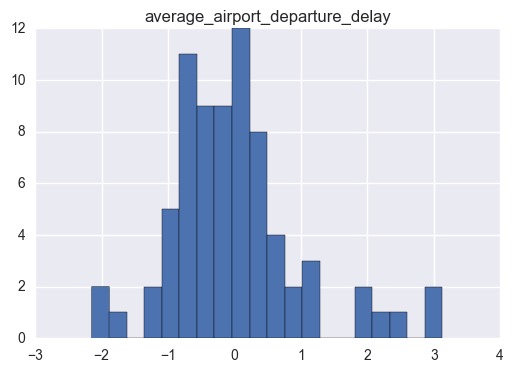

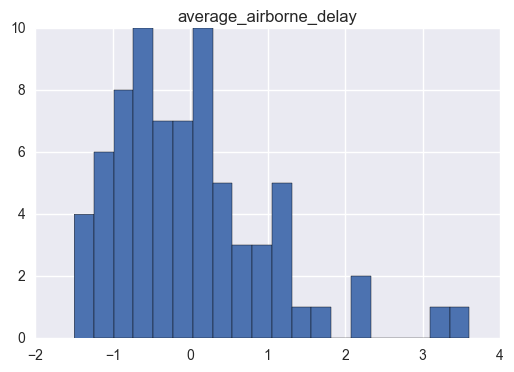

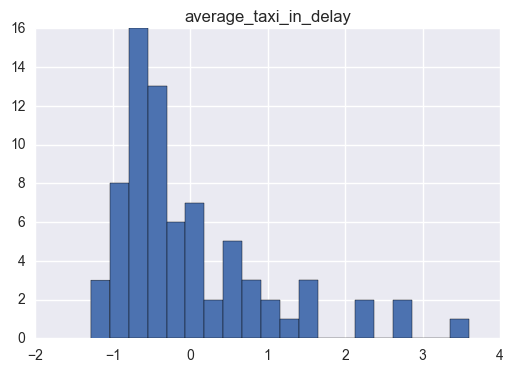

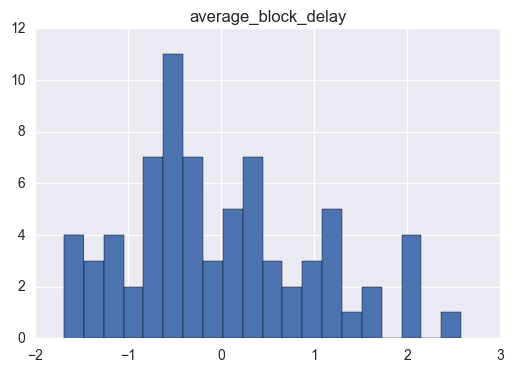

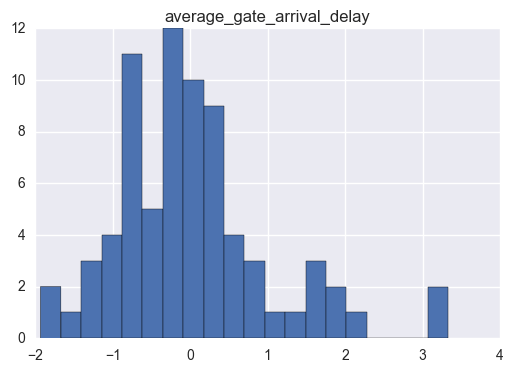

In [175]:
for x in X.columns[0:17]:
    plt.hist(X[x],bins=20)
    plt.title(x)
    plt.show()
    

#### 4.3 What is the value of understanding correlations before PCA? 

As mentioned earlier there is quite a lot of correlation betwene the data, this will mean that the majority of the data should be able to be descirbed by quite a just a few Principal components.

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [125]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
X_reduced = pca.transform(X)

In [276]:
print 'Explained variance: '
print pca.explained_variance_ratio_
print 'Cumulative variance: '
print np.cumsum(pca.explained_variance_ratio_)

Explained variance: 
[  5.13942649e-01   2.27746959e-01   6.35320709e-02   3.46806581e-02
   2.38579952e-02   2.03217205e-02   1.56298726e-02   1.42241790e-02
   1.01632911e-02   8.36540177e-03   6.90374936e-03   6.30229254e-03
   6.12607921e-03   4.94574367e-03   4.26211506e-03   3.63588774e-03
   3.35945055e-03   3.11024031e-03   2.67153592e-03   2.11231177e-03
   2.05278737e-03   1.72319568e-03   1.61414648e-03   1.38682468e-03
   1.32820510e-03   1.26453406e-03   1.13762468e-03   1.11078065e-03
   1.00971151e-03   9.52692919e-04   9.04863549e-04   8.27317346e-04
   7.60025378e-04   7.52438611e-04   7.29984418e-04   7.23716078e-04
   7.10471431e-04   7.06645144e-04   6.91579713e-04   6.58821288e-04
   6.14606040e-04   5.34676537e-04   4.45461235e-04   3.71708876e-04
   3.04843448e-04   2.81969949e-04   1.81127404e-04   1.58313140e-04
   9.39711398e-05   4.87427244e-05   1.59051346e-05   7.23820284e-06
   8.67187978e-07   3.44039916e-33   3.44039916e-33   3.44039916e-33
   3.44039916

In [127]:
len(np.cumsum(pca.explained_variance_ratio_))

64

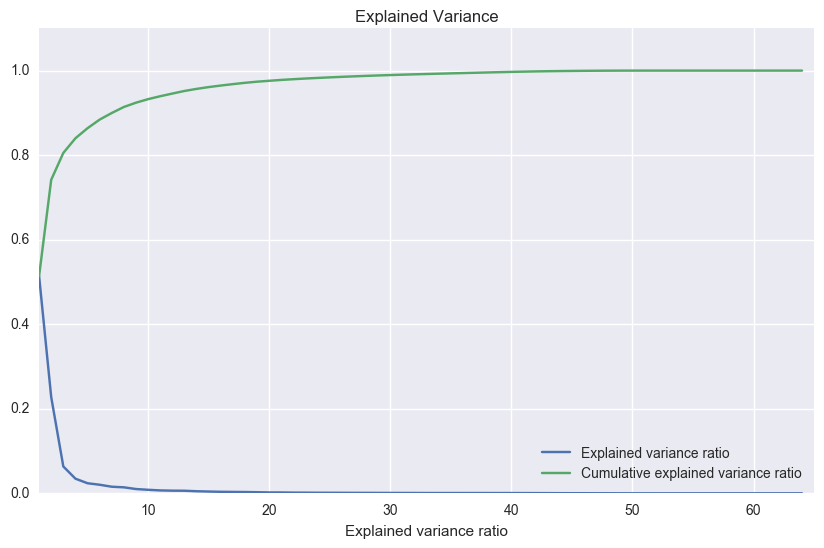

In [131]:
plt.figure(figsize=(10,6))
plt.title('Explained Variance')
plt.plot(list(range(1,65)), pca.explained_variance_ratio_, label = 'Explained variance ratio' )
plt.plot(list(range(1,65)), np.cumsum(pca.explained_variance_ratio_), label = 'Cumulative explained variance ratio')
plt.xlabel('n_components')
plt.xlabel('Explained variance ratio')
plt.xlim((1,65))
plt.ylim((0,1.1))
plt.legend(loc=4)
plt.show()

As predicted, the majority of the variance can be explained within the first 3 principal components, this is where the 'elbow' occurs on the graph above.

In [132]:
X3=X_reduced[:,:3]
X3.shape

(74, 3)

In [133]:
from scipy.cluster.hierarchy import linkage,cophenet,dendrogram,fcluster
from scipy.spatial.distance import pdist
# Hierachical Clustering

Z = linkage(X3, 'average')
c, coph_dists = cophenet(Z, pdist(X_reduced))
print 'Cophantic Coefficiant:', c
print 'Mean distance:', coph_dists.mean()

Cophantic Coefficiant: 0.890297711491
Mean distance: 4.60643081704


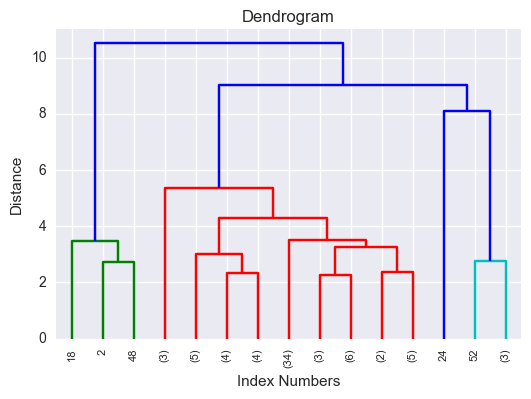

In [134]:

plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p = 15,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

From the Dendogram, we can see that the majority of the data falls within quite a tight clusters, with an additional three ourlier clusters. I will cut the dendogram above these in order to visualise the four clusters.

In [135]:
max_d = list(range(1,30))
number_clusters = []

for i in max_d:

    clusters = fcluster(Z, i, criterion='distance')
    number_clusters.append(clusters.max())

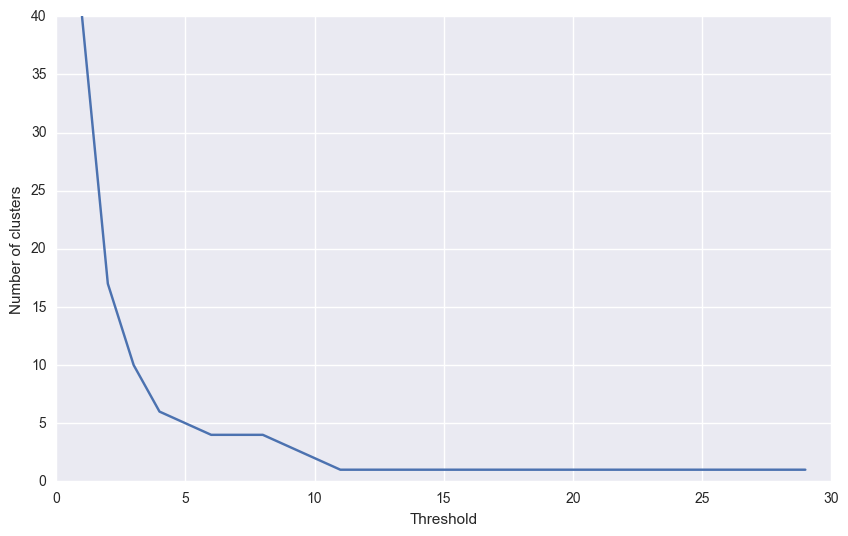

In [136]:
plt.figure(figsize=(10,6))
plt.plot(max_d, number_clusters)
plt.xlabel('Threshold')
plt.ylabel('Number of clusters')
plt.show()

In [171]:
# We want to use three clusters - One group being outliars

clusters = fcluster(Z, 5.5, criterion='distance')
print 'Number of clusters: ', clusters.max()

Number of clusters:  4


In [172]:
pca_data = pd.DataFrame(X3, columns = ['component_1', 'component_2', 'component_3'])
pca_data_frame = pd.concat([pca_data, y, pd.DataFrame(clusters, columns = ['cluster']) ], axis = 1)

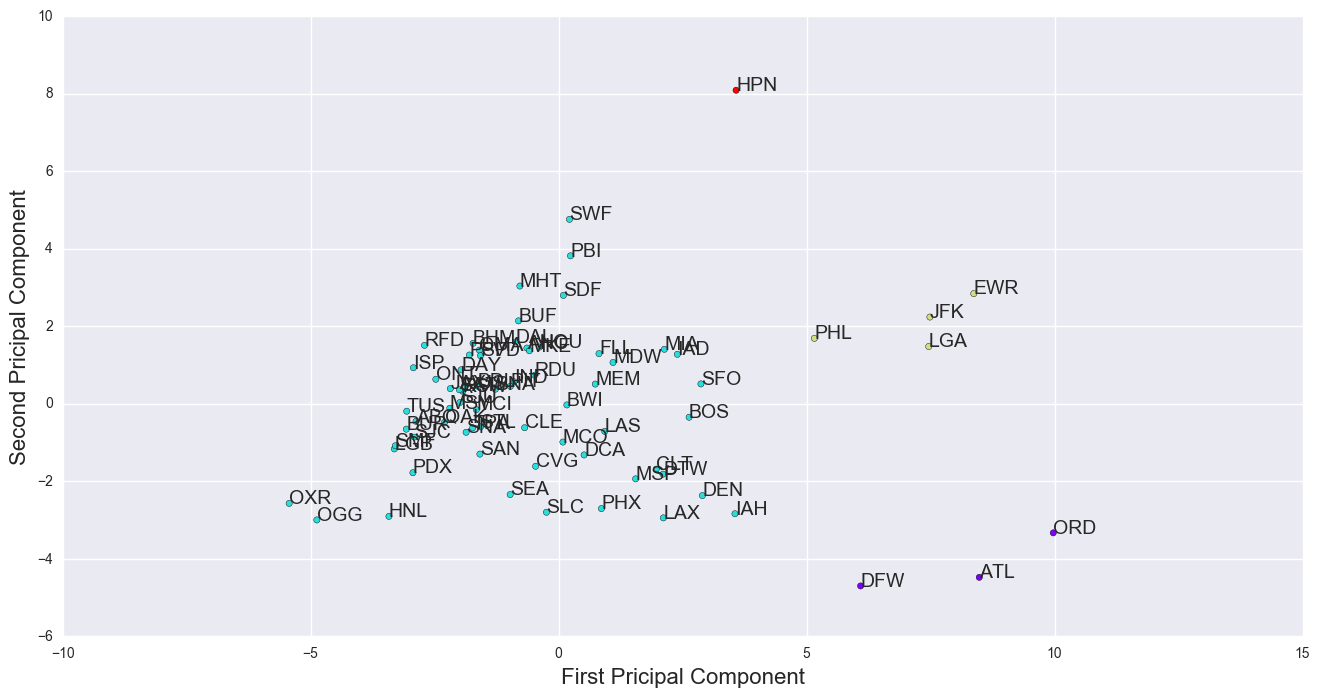

In [279]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.scatter(pca_data_frame.component_1,pca_data_frame.component_2, 
    c = clusters,
    cmap = plt.get_cmap('rainbow'))
for i, xi in enumerate(pca_data_frame.airport):
    ax.annotate(xi[:3], (pca_data_frame.iloc[i,0], pca_data_frame.iloc[i,1]),fontsize=14)
plt.xlabel('First Pricipal Component',fontsize=16)
plt.ylabel('Second Pricipal Component',fontsize=16)
plt.show()

We can see from the graph above that the data above that clusters are well split, it may be possible to split the data into just two clusters - regular airports and outliers, to do so I will use DBSCAN as this will cluster the data around the dense region.

In [174]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps= 4.2, min_samples= 10)  
model = db.fit_predict(X_reduced)
labels = db.labels_
print np.unique(db.labels_)

[-1  0]


In [158]:
bdscan_data_frame = pd.concat([pca_data, y, 
                               pd.DataFrame(labels, columns = ['labels']) ], axis = 1)

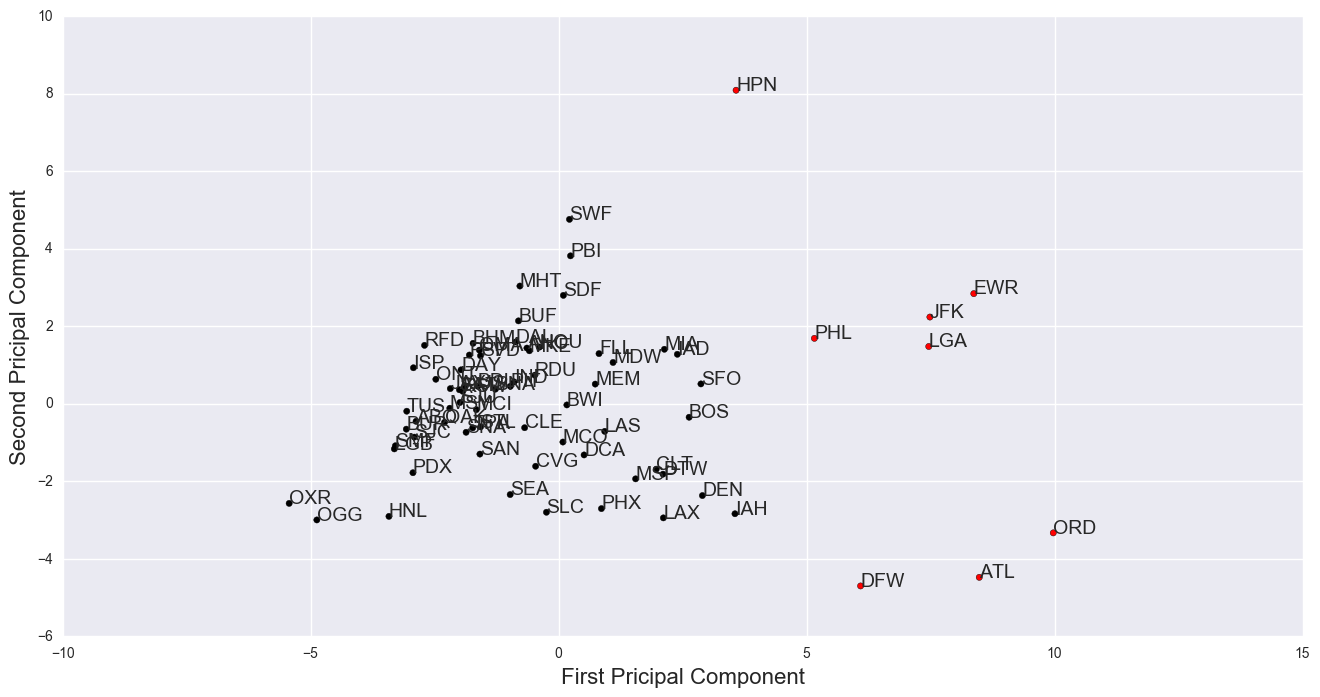

In [280]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.scatter(bdscan_data_frame.component_1,bdscan_data_frame.component_2, 
    c = labels,
    cmap = plt.get_cmap('flag'))
for i, xi in enumerate(bdscan_data_frame.airport):
    ax.annotate(xi[:3], (bdscan_data_frame.iloc[i,0], bdscan_data_frame.iloc[i,1]),fontsize=14)
plt.xlabel('First Pricipal Component',fontsize=16)
plt.ylabel('Second Pricipal Component',fontsize=16)
plt.show()

Using DBScan I was able to cluster the outliers and the rest of the data quite easily. I will now examine the cluster labels when compared to the original data to see if there are any noticible links.

In [253]:
Output_Df=df.groupby(['airport','faa_region']).mean().reset_index().join(pca_data_frame.cluster)

In [254]:
Output_Df.cluster.value_counts()

2    66
3     4
1     3
4     1
Name: cluster, dtype: int64

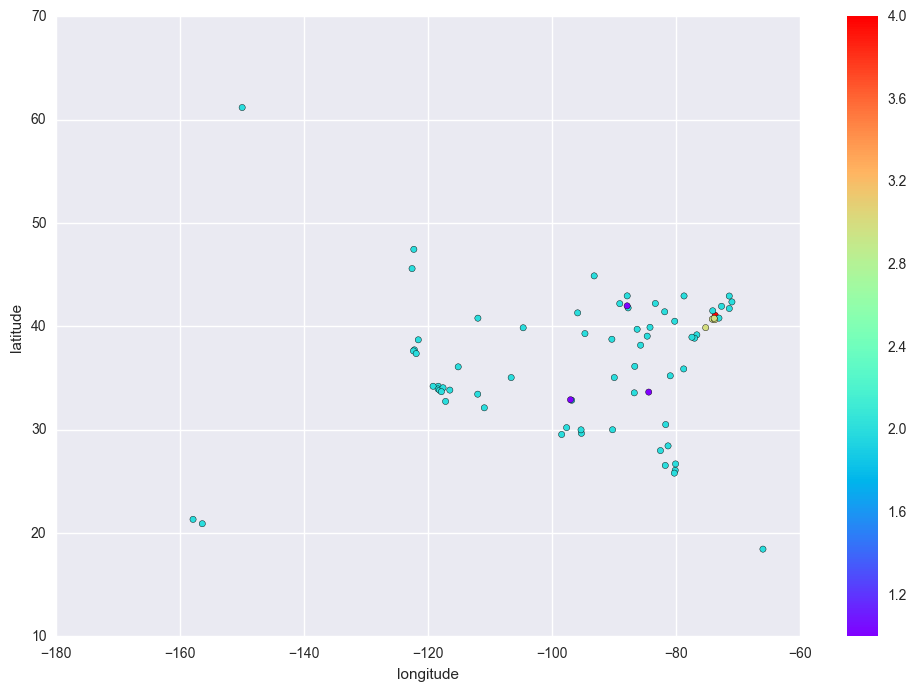

In [285]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
Output_Df.plot(kind='scatter',
               x='longitude',
               y='latitude',
               c=Output_Df.cluster,
               cmap = plt.get_cmap('rainbow'),
               ax=ax1)

All of the airports with significantly larger delays are located in the eastern side of the USA, with those with a high 1st PCA and low 2nd PCA all group quite closely around the state of New York.

In [256]:
mean_values=Output_Df[Output_Df.cluster==2].mean()

In [265]:
Comparison_df=Output_Df[Output_Df.cluster!=2].drop([u'year', u'latitude',u'longitude'],axis=1)
for x in Comparison_df.ix[:,2:-1].columns:
    Comparison_df[x]=(Comparison_df[x]/mean_values[x])

In [266]:
Comparison_df

,airport,faa_region,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,cluster
2,ATL,ASO,7.545085,8.259620,6.271196,7.408109,5.004693,4.991522,0.982481,0.851170,0.998063,1.087158,1.523593,2.506022,1.368835,1.223661,2.931035,1.342779,1.134027,1
18,DFW,ASW,6.951082,7.257978,4.642322,10.377838,3.582665,3.588424,0.977459,0.957267,1.029125,1.093611,1.213830,1.420128,1.159194,0.869050,3.417684,1.218383,1.015223,1
20,EWR,AEA,4.877140,4.915957,2.308914,4.080869,2.152408,2.145328,0.930685,0.713115,0.875814,1.426835,1.887098,3.704987,1.900718,1.818863,2.095932,1.683414,1.752149,3
24,HPN,AEA,0.381090,0.321088,0.194666,0.646298,0.337491,0.342160,0.742791,0.726969,0.754188,1.765413,1.064799,1.091753,1.675638,1.479862,1.103317,1.556984,1.759733,4
30,JFK,AEA,2.858909,2.788199,1.942788,3.398279,2.039940,2.032391,0.936645,0.735850,0.924723,1.387089,2.205269,3.692977,1.870956,1.863317,2.605612,1.569191,1.430612,3
33,LGA,AEA,5.295440,5.146947,1.802268,4.394366,1.982705,1.993281,0.973478,0.729986,0.924559,1.234850,1.908258,3.861998,1.758044,2.217588,1.875268,1.463687,1.439969,3
48,ORD,AGL,12.523090,13.241149,5.211494,6.532479,4.714732,4.739507,0.928903,0.852929,0.968377,1.402196,1.373511,2.097677,1.564090,1.134075,2.936236,1.421543,1.380779,1
52,PHL,AEA,2.293649,2.210980,1.578596,2.375166,2.376141,2.382846,0.946434,0.804602,0.946344,1.275917,1.549448,2.685296,1.581266,2.371988,1.690267,1.319527,1.328537,3


## Summary

From the table above we can see that the majority of the airports fall within the AEA faa_region, this is as what was predicted earlier in the analysis, this is unsurpsiing as this is one of the most densely populated areas of the US. With a lot of air travel, so airborn delays will be expected due to congested timetables. Any delays that would occur will have a knock on effect. We can also see, that with the exception of HPN, all of these airports are much larger then the average, with almost all of them having over double the departures/arrivals compared to the average.

Again with the exception of HPN, the majority of these airports have long taxi out time and with it much longer then average taxi delays.

HPN really is an exception, it is a much smaller airport, with a very poor departure performance mostly due to the gate delay, which is something that should be able to be improved upon as it points to inefficienes within the airport rather then due to a congested timetable or other delays where there is less control over.

Those outside of the AEA region tend to have very high cancellations and diversions rather then delays themselves, this would need to be looked at on an indivudal basis.

In [286]:
Output_Df[Output_Df.faa_region=='AEA']

,airport,faa_region,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,latitude,longitude,departures_for_metric_computation,...,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,cluster
8,BUF,AEA,2009.0,491.545455,436.454545,47.181818,35.454545,42.940417,-78.730583,38447.000000,...,0.733809,14.830000,12.520909,2.903636,16.894545,2.718182,0.958182,3.060909,15.729091,2
10,BWI,AEA,2009.0,1402.272727,1312.363636,175.909091,198.545455,39.175361,-76.668333,124995.727273,...,0.784245,13.496364,12.507273,3.470000,16.310000,3.393636,1.439091,2.840000,12.548182,2
16,DCA,AEA,2009.0,2468.363636,2349.909091,164.363636,211.000000,38.851916,-77.037699,137145.181818,...,0.812000,12.090909,15.682727,4.722727,15.820909,3.709091,1.367273,3.113636,11.364545,2
20,EWR,AEA,2009.0,4241.909091,4355.090909,325.636364,480.454545,40.692500,-74.168667,201708.272727,...,0.677209,17.688182,24.484545,11.498182,27.867273,4.872727,2.564545,5.265455,22.470909,3
24,HPN,AEA,2009.0,331.454545,284.454545,27.454545,76.090909,41.066944,-73.707556,31627.272727,...,0.583164,21.885455,13.815455,3.388182,24.567273,3.964545,1.350000,4.870000,22.568182,4
25,IAD,AEA,2009.0,2100.545455,2211.727273,188.909091,163.818182,38.947444,-77.459944,166881.272727,...,0.750627,16.571818,17.021818,4.646364,20.410909,3.660000,1.540909,3.137273,15.373636,2
28,ISP,AEA,2009.0,137.636364,134.545455,23.454545,30.000000,40.795250,-73.100222,10994.818182,...,0.759318,12.056364,8.876364,1.691818,13.372727,2.230000,0.670909,2.191818,13.995455,2
30,JFK,AEA,2009.0,2486.545455,2470.090909,274.000000,400.090909,40.639751,-73.778926,191168.545455,...,0.715027,17.195455,28.612727,11.460909,27.430909,4.991818,3.188182,4.908182,18.347273,3
33,LGA,AEA,2009.0,4605.727273,4559.727273,254.181818,517.363636,40.777250,-73.872611,185804.909091,...,0.714900,15.308182,24.759091,11.985455,25.775455,5.940909,2.294545,4.578182,18.467273,3
52,PHL,AEA,2009.0,1994.909091,1958.727273,222.636364,279.636364,39.872249,-75.240866,222674.909091,...,0.731745,15.817273,20.103636,8.333636,23.183636,6.354545,2.068182,4.127273,17.038182,3


### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

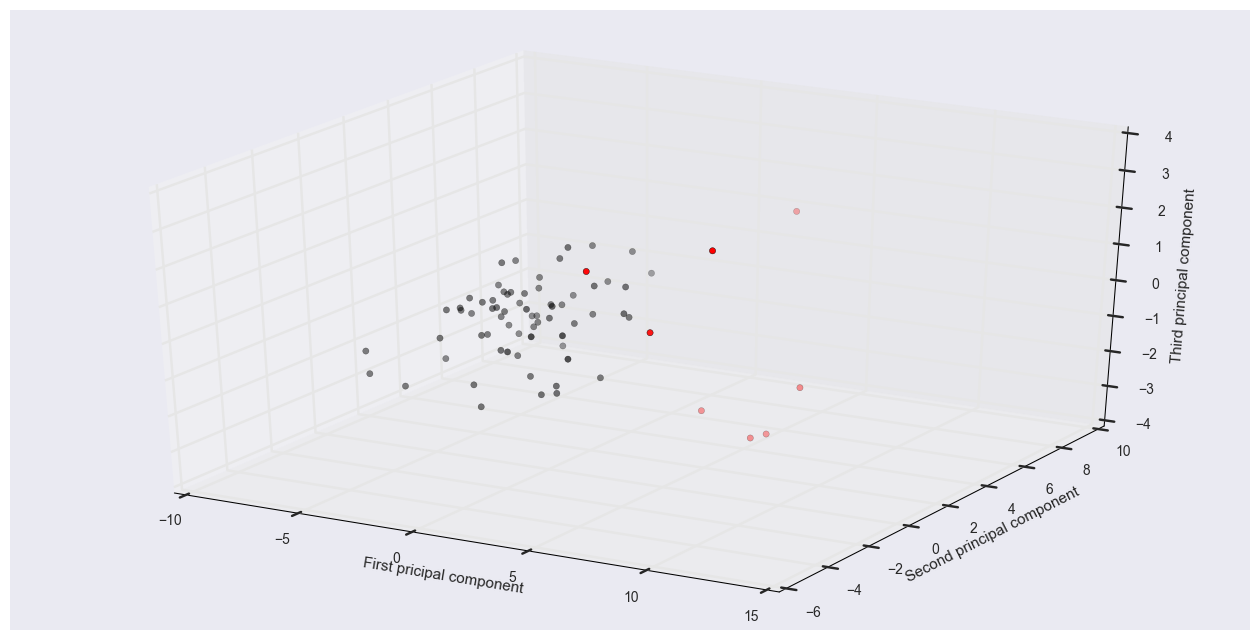

In [224]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(bdscan_data_frame['component_1'], 
           bdscan_data_frame['component_2'],
           bdscan_data_frame['component_3'],  
           c= labels, cmap='flag')

ax.set_xlabel('First pricipal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')

plt.show()